# Process

# Todo
- postgres db (import export)
- analyze data directly from db
  - 02_eda
- create features
  - trend
  - weekend
  - is_nice_day
- analyze features
  - violin plot
- train model
  - all
  - cross-validation
  - convolution rnn
- validate
  - plot
  - mse
  - gütemass
- create predictions
  - some examples
  - where is it cheapest to go tomorrow? as LLM and geo
- modellhypothesen
  - is is more expensive on weekends???
  - analyse


In [14]:
!pip install sqlalchemy pandas psycopg2-binary matplotlib seaborn tensorflow setuptools

# Import
You first have to import the data from `ds/dump.sql`. To do so run `docker compose up -d` and `data/scripts/import.sh`.
This will import the data from the database dump. Originally the data was stored in a GCP cloud SQL instance and the dump was exported with the script `data/scripts/export.sh`

In [317]:
import matplotlib.pyplot as plt
import datetime
import random
import pandas as pd
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from tensorflow import keras


url = URL.create(
    drivername="postgresql",
    username="postgres",
    password="password",
    host="localhost",
    database="data",
)
db = create_engine(url)
conn = db.connect()

data = pd.read_sql_query("""
                         SELECT 
                         P.resort, P.date, 
                         MAX(P.price) as max_price, 
                         AVG(P.price) as avg_price, 
                         MIN(P.price) as min_price,
                         MAX(W.apparent_temperature) as max_apparent_temperature,
                         AVG(W.apparent_temperature) as avg_apparent_temperature,
                         MIN(W.apparent_temperature) as min_apparent_temperature,
                         MAX(W.precipitation) as max_precipitation,
                         AVG(W.precipitation) as avg_precipitation,
                         MIN(W.precipitation) as min_precipitation,
                         MAX(W.temperature_2m) as max_temp,
                         AVG(W.temperature_2m) as avg_temp,
                         MIN(W.temperature_2m) as min_temp,
                         MAX(W.wind_speed_100m) as max_wind,
                         AVG(W.wind_speed_100m) as avg_wind,
                         MIN(W.wind_speed_100m) as min_wind,
                         MAX(W.rain) as max_rain,
                         MIN(W.rain) as min_rain,
                         AVG(W.rain) as avg_rain,
                         MAX(W.snow_depth) as max_snow_depth,
                         MAX(W.cloud_cover) as max_cloud_cover,
                         SUM(W.snowfall) as sum_snow
                         FROM prices as P
                         INNER JOIN weather as W 
                         ON Date(W.date) = Date(P.date)
                         AND W.resort = P.resort
                         GROUP BY P.resort, P.date
                         """, conn)
data.index = pd.to_datetime(data["date"]).apply(lambda x: x.date())

data.describe()

,max_price,avg_price,min_price,max_apparent_temperature,avg_apparent_temperature,min_apparent_temperature,max_precipitation,avg_precipitation,min_precipitation,max_temp,...,min_temp,max_wind,avg_wind,min_wind,max_rain,min_rain,avg_rain,max_snow_depth,max_cloud_cover,sum_snow
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,...,197.000000,197.000000,197.000000,197.000000,197.000000,197.0,197.000000,193.000000,197.000000,197.000000
mean,69.345178,64.368646,61.631980,-0.633015,-5.410601,-10.957961,0.984264,0.212225,0.000508,2.384901,...,-7.059515,16.616889,10.645255,5.096181,0.166497,0.0,0.031113,2.014301,96.408630,5866.631017
std,10.250567,8.288984,7.340678,6.609045,5.606393,5.874564,1.245361,0.302477,0.007125,5.862051,...,5.412001,8.499340,6.042137,5.096970,0.431058,0.0,0.089037,0.366185,11.961595,10869.360097
min,55.000000,51.188216,49.000000,-12.862125,-17.148169,-25.281313,0.000000,0.000000,0.000000,-8.233500,...,-20.233500,5.804825,3.372073,0.360000,0.000000,0.0,0.000000,1.360000,30.000002,0.000000
25%,64.000000,58.394248,55.000000,-4.816090,-9.251680,-15.092754,0.000000,0.000000,0.000000,-1.333500,...,-10.633500,10.495713,6.350186,1.484318,0.000000,0.0,0.000000,1.690000,100.000000,0.000000
50%,67.000000,64.000000,64.000000,-2.410789,-6.586293,-11.365122,0.400000,0.070833,0.000000,0.925000,...,-7.532000,13.441071,9.158194,3.075841,0.000000,0.0,0.000000,2.060000,100.000000,755.580000
75%,74.000000,68.236061,67.000000,2.164895,-2.143950,-6.616779,1.700000,0.333333,0.000000,4.561000,...,-2.975000,21.178896,13.354118,7.208994,0.100000,0.0,0.008333,2.260000,100.000000,6957.300166
max,94.500000,90.430836,83.500000,22.771229,12.119329,1.769660,6.000000,2.037500,0.100000,22.530500,...,4.730500,45.923640,35.402309,27.852928,3.200000,0.0,0.579167,2.810000,100.000000,76383.718110


In [318]:
def get_mondays(start, end):
    start = start - datetime.timedelta(days=start.weekday())
    end = end - datetime.timedelta(days=end.weekday())
    current = start
    while current <= end:
        yield current
        current = current + datetime.timedelta(days=7)

def print_groups(groups, cols):
    fig = plt.figure(figsize=(40, 20))
    for index, (group_name, df) in enumerate(groups):
        axis = fig.add_subplot(
            5,1,index+1,
            yticks=[],
            title=group_name
        )
        #df = df[df.index >= datetime.datetime.strptime("2024-02-19", '%Y-%m-%d').date()]
        
        for monday in get_mondays(df.index.min(), df.index.max()):
            axis.vlines(monday, 0, 1, color='black', linestyle='--')
            axis.text(monday,0, monday.strftime('%a %Y-%m-%d') ,rotation=90)

        for index, (col, color, pltarea) in enumerate(cols):
            ax = axis.twinx()
            if index > 0:
                ax.plot(df.index, df[col], color=color)
                if len(pltarea):
                    ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
                ax.set_yticks([])
                sax = ax.secondary_yaxis(1.0 + 0.02 * (index - 1))
                sax.set_ylabel(col, color=color)
                sax.tick_params(axis='y', labelcolor=color)
            else:
                ax.scatter(df.index, df[col], color=color, marker='x')
                if len(pltarea):
                    ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
                ax.yaxis.set_ticks_position("left")
                ax.yaxis.set_label_position("left")
                ax.set_ylabel(col, color=color)
                ax.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    return fig

def print_violins(groups, drop_cols=[]):
    fig = plt.figure(figsize=(20, 35)) 
    for index, (group_name, df) in enumerate(groups):
        df = df.drop(columns=drop_cols)
        df_mean = df.mean()
        df_std = df.std()
        df_std = (df - df_mean) / df_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        axis = fig.add_subplot(
            2*len(groups.groups),1,index+1,
            title=f"{group_name} - Features"
        )
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std, ax=axis)
        ax.tick_params(axis='x', labelrotation=45)
    fig.tight_layout()
    return fig

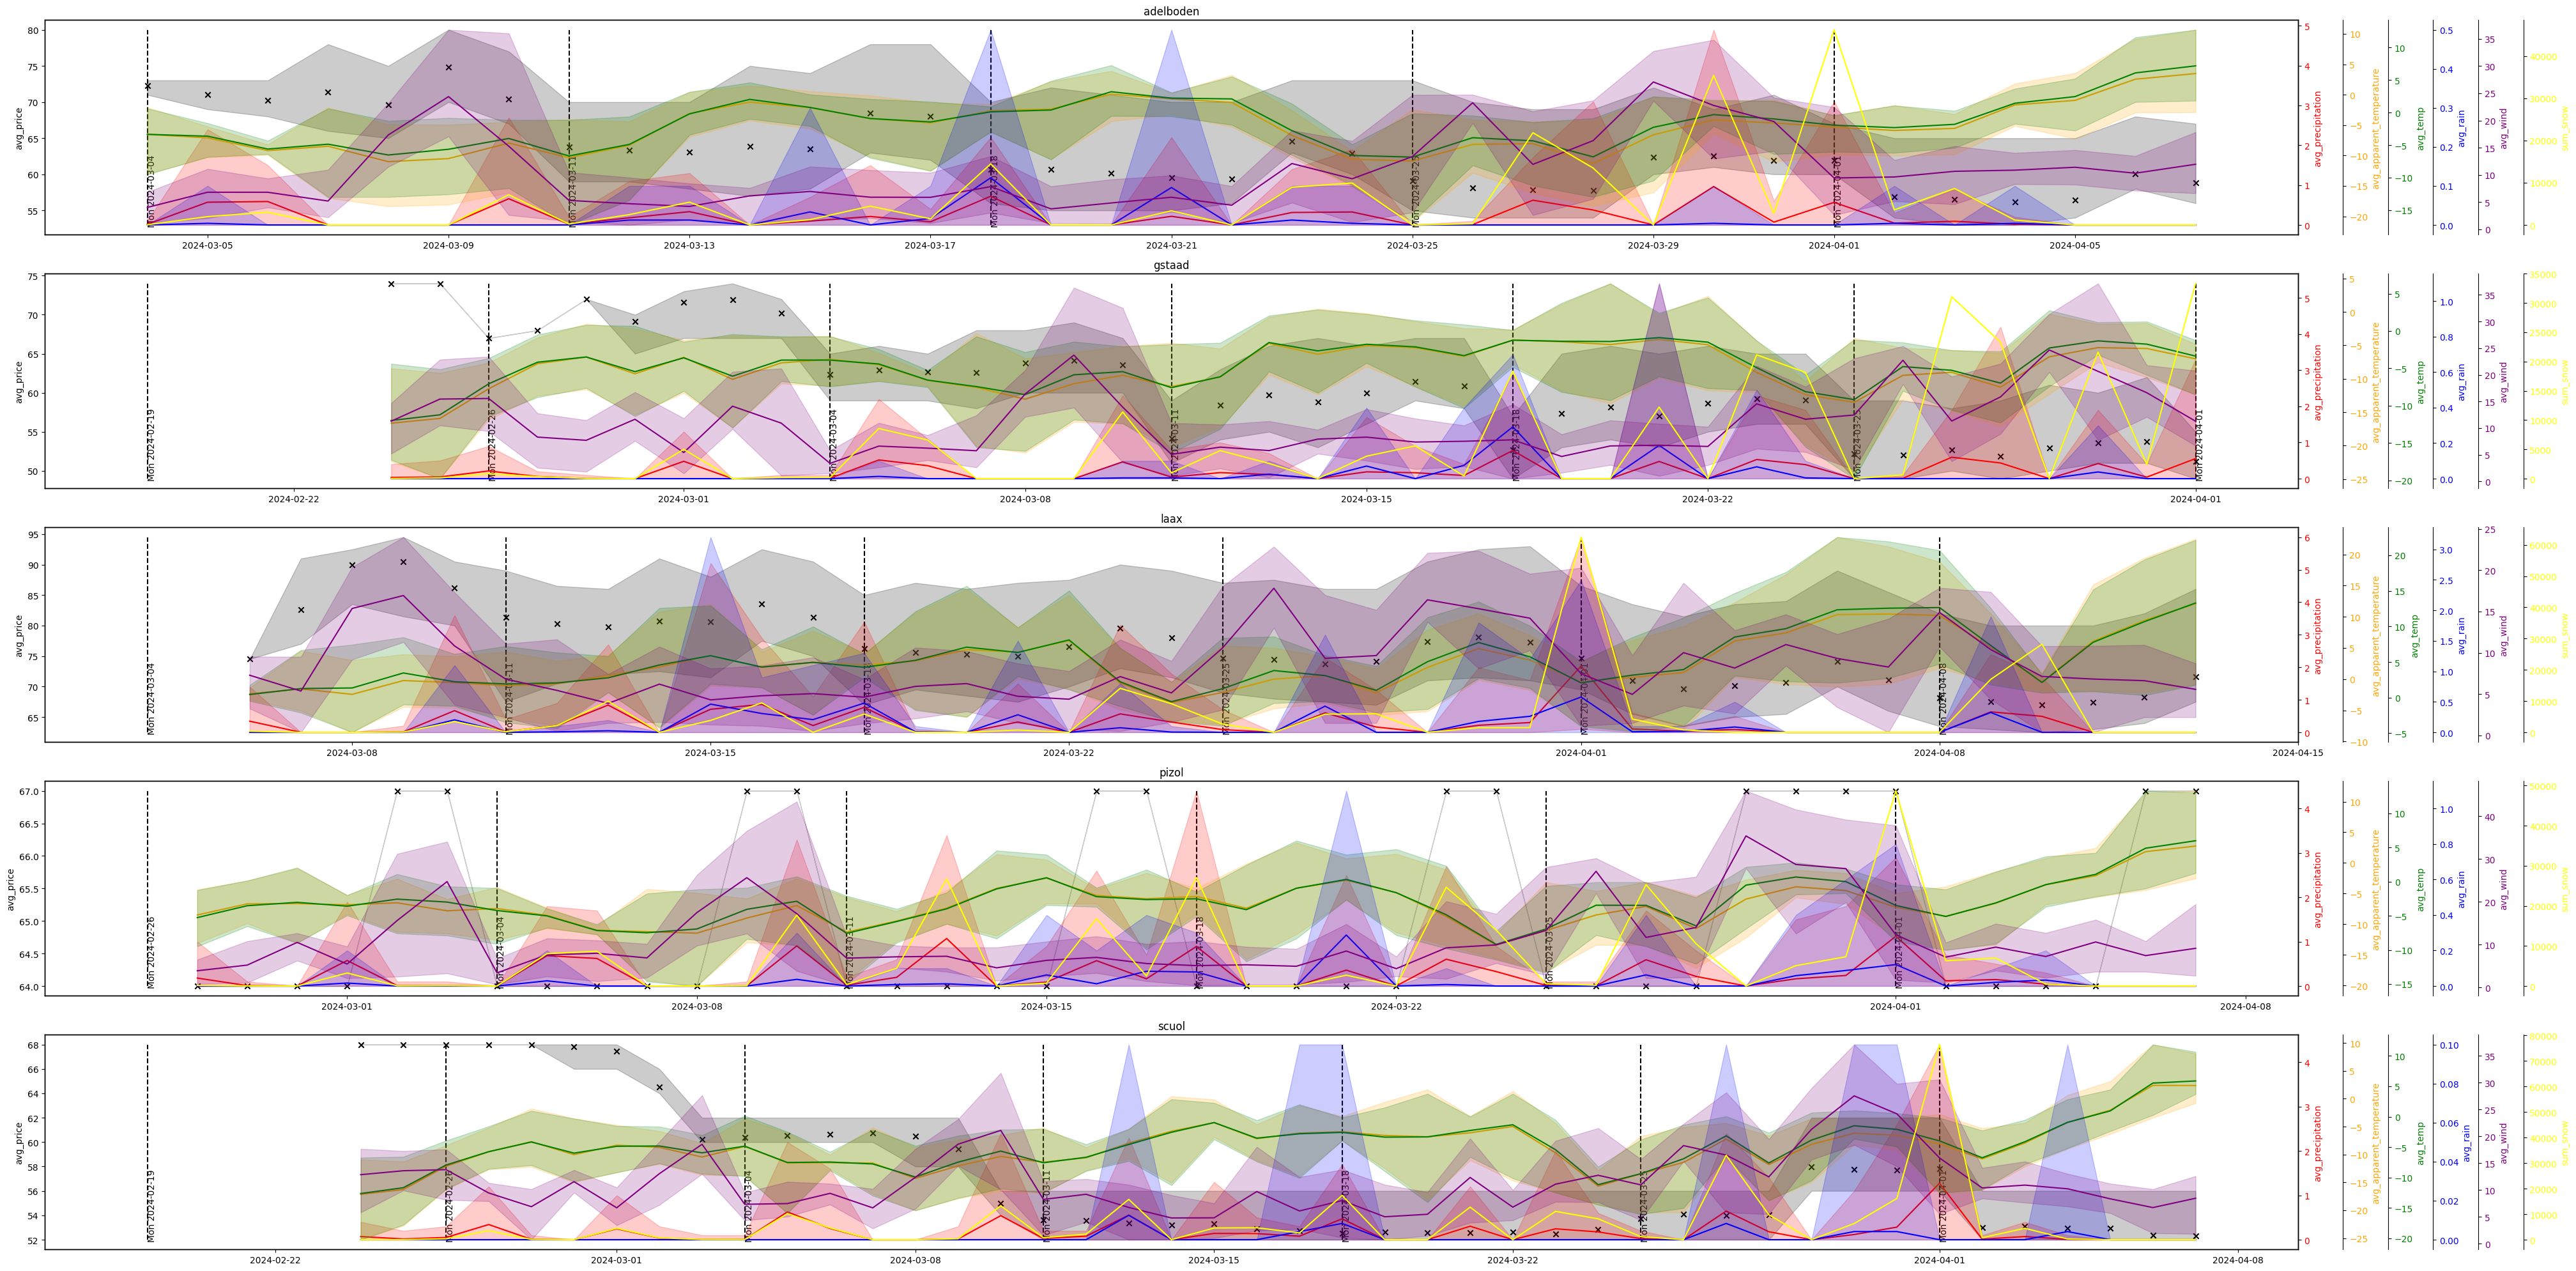

In [319]:
# Plot the data by resort
groups = data.groupby("resort")
fig = print_groups(
    groups, [
    ('avg_price', 'black', ["min_price", "max_price"]),
    ('avg_precipitation', 'red', ["max_precipitation", "min_precipitation"]),
    ('avg_apparent_temperature', 'orange', ["max_apparent_temperature", "min_apparent_temperature"]),
    ('avg_temp', 'green', ["max_temp", "min_temp"]),
    ('avg_rain', 'blue', ["max_rain", "min_rain"]),
    ('avg_wind', 'purple', ["max_wind", "min_wind"]),
    ('sum_snow', 'yellow', [])
])

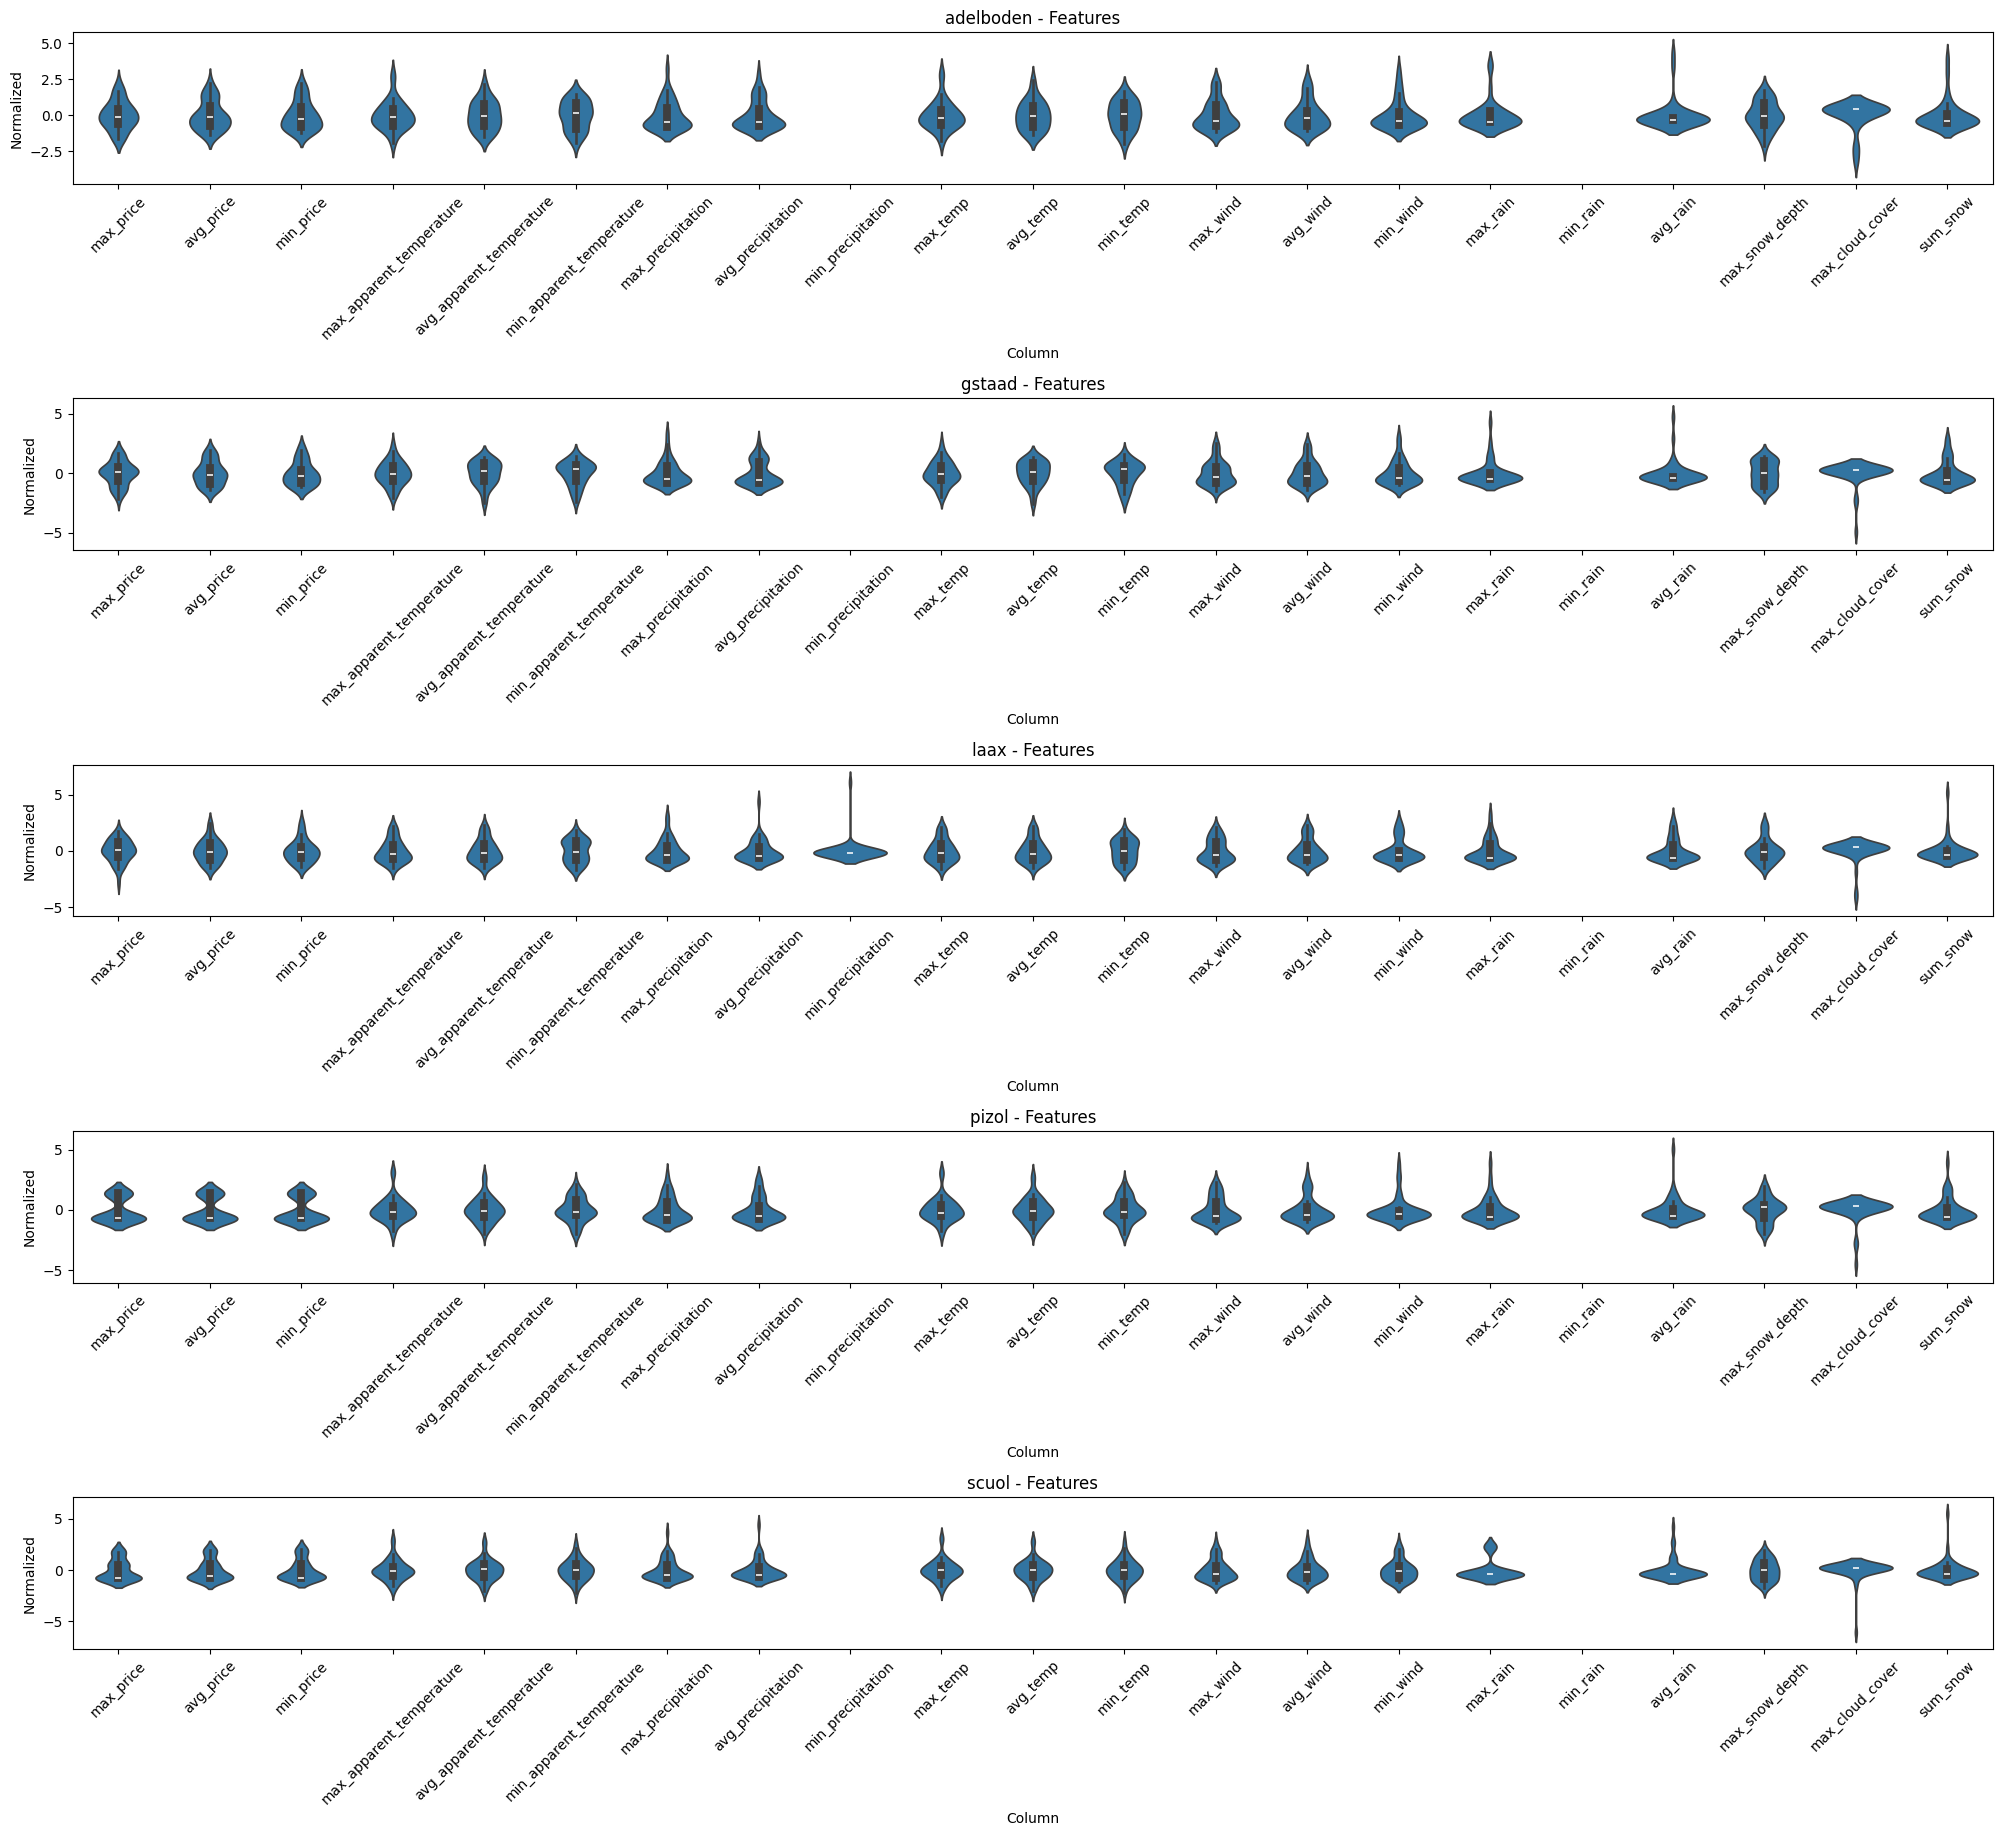

In [320]:
groups = data.groupby("resort")
fig = print_violins(groups, drop_cols=["date", "resort"])

Epoch 1/100


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 7717.5894 - mean_absolute_error: 87.8392 - val_loss: 7667.9150 - val_mean_absolute_error: 87.5555 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7694.1089 - mean_absolute_error: 87.7087 - val_loss: 7658.2314 - val_mean_absolute_error: 87.5002 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7714.5010 - mean_absolute_error: 87.8244 - val_loss: 7648.2300 - val_mean_absolute_error: 87.4429 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7700.2920 - mean_absolute_error: 87.7396 - val_loss: 7637.4312 - val_mean_absolute_error: 87.3811 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 7668.2031 - mean_absolute_error: 87.5598 - val_loss: 7624.7788 - val_mean_absolute_error: 87.3085 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7722.2593 - mean_absolute_error: 8

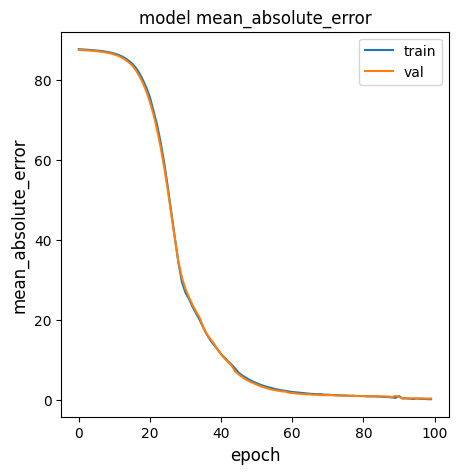

In [321]:
groups = data.groupby("resort")

X_WINDOW_SIZE = 7
Y_WINDOW_SIZE = 3

selected_freatures = data.drop(columns=["resort", "date", "avg_price", "min_price"]).columns
selected_targets = data[["max_price"]].columns

model = keras.Sequential()
model.add(keras.Input(shape=(X_WINDOW_SIZE, len(selected_freatures))))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"))
#model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=False)))
#model.add(keras.layers.Dense(512))
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Dense(Y_WINDOW_SIZE * len(selected_freatures)))
model.add(keras.layers.Reshape(target_shape=(Y_WINDOW_SIZE, len(selected_freatures))))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()]
)

data_chunks = []
for group_index, (group_name, group) in enumerate(groups):
    #print(group_name)
    for index in range(len(group.index) - (X_WINDOW_SIZE + Y_WINDOW_SIZE -1)):
        date = group.iloc[index].date
        #print(date , group.iloc[index+X_WINDOW_SIZE+Y_WINDOW_SIZE].date, group.iloc[index+X_WINDOW_SIZE+Y_WINDOW_SIZE].max_price)
        df = group#.reset_index(drop=True)
        feature_df = df[selected_freatures]
        target_df = df[selected_targets]
        X = np.array(
            feature_df.iloc[index:index+X_WINDOW_SIZE],
            dtype=np.float32
        )
        Y = np.array(
            target_df.iloc[index+X_WINDOW_SIZE-(X_WINDOW_SIZE-Y_WINDOW_SIZE):index+X_WINDOW_SIZE+Y_WINDOW_SIZE],
            dtype=np.float32
        )
        data_chunks.append((
            np.reshape(X, (X.shape[0], 1, X.shape[1])),
            np.reshape(Y, (Y.shape[0], 1, Y.shape[1])),
            date,
            group_name
        ))

random_data = data_chunks.copy()
random.Random(42).shuffle(random_data)
train_val_split = int(len(random_data) * 0.7)
X_train, Y_train, dates_train, _ = zip(*random_data[:train_val_split])
X_val, Y_val, dates_val, _ = zip(*random_data[train_val_split:])
history = model.fit(
    X_train, Y_train, 
    batch_size=1,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00000001),
        keras.callbacks.TerminateOnNaN()
    ]
)

metric = "mean_absolute_error"
plt.figure(figsize=(5, 5))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

[[[67.]]

 [[64.]]

 [[64.]]

 [[64.]]

 [[64.]]

 [[67.]]

 [[67.]]]
2024-02-27 00:00:00 4 [[64.]]
2024-02-28 00:00:00 5 [[64.]]
2024-02-29 00:00:00 6 [[64.]]
2024-02-28 00:00:00 4 [[64.]]
2024-02-29 00:00:00 5 [[64.]]
2024-03-01 00:00:00 6 [[64.]]
2024-02-29 00:00:00 4 [[64.]]
2024-03-01 00:00:00 5 [[64.]]
2024-03-02 00:00:00 6 [[67.]]
2024-03-01 00:00:00 4 [[64.]]
2024-03-02 00:00:00 5 [[67.]]
2024-03-03 00:00:00 6 [[67.]]
2024-03-02 00:00:00 4 [[67.]]
2024-03-03 00:00:00 5 [[67.]]
2024-03-04 00:00:00 6 [[64.]]
2024-03-03 00:00:00 4 [[67.]]
2024-03-04 00:00:00 5 [[64.]]
2024-03-05 00:00:00 6 [[64.]]
2024-03-04 00:00:00 4 [[64.]]
2024-03-05 00:00:00 5 [[64.]]
2024-03-06 00:00:00 6 [[64.]]
2024-03-05 00:00:00 4 [[64.]]
2024-03-06 00:00:00 5 [[64.]]
2024-03-07 00:00:00 6 [[64.]]
2024-03-06 00:00:00 4 [[64.]]
2024-03-07 00:00:00 5 [[64.]]
2024-03-08 00:00:00 6 [[64.]]
2024-03-07 00:00:00 4 [[64.]]
2024-03-08 00:00:00 5 [[64.]]
2024-03-09 00:00:00 6 [[67.]]
2024-03-08 00:00:00 4 [[64.]]


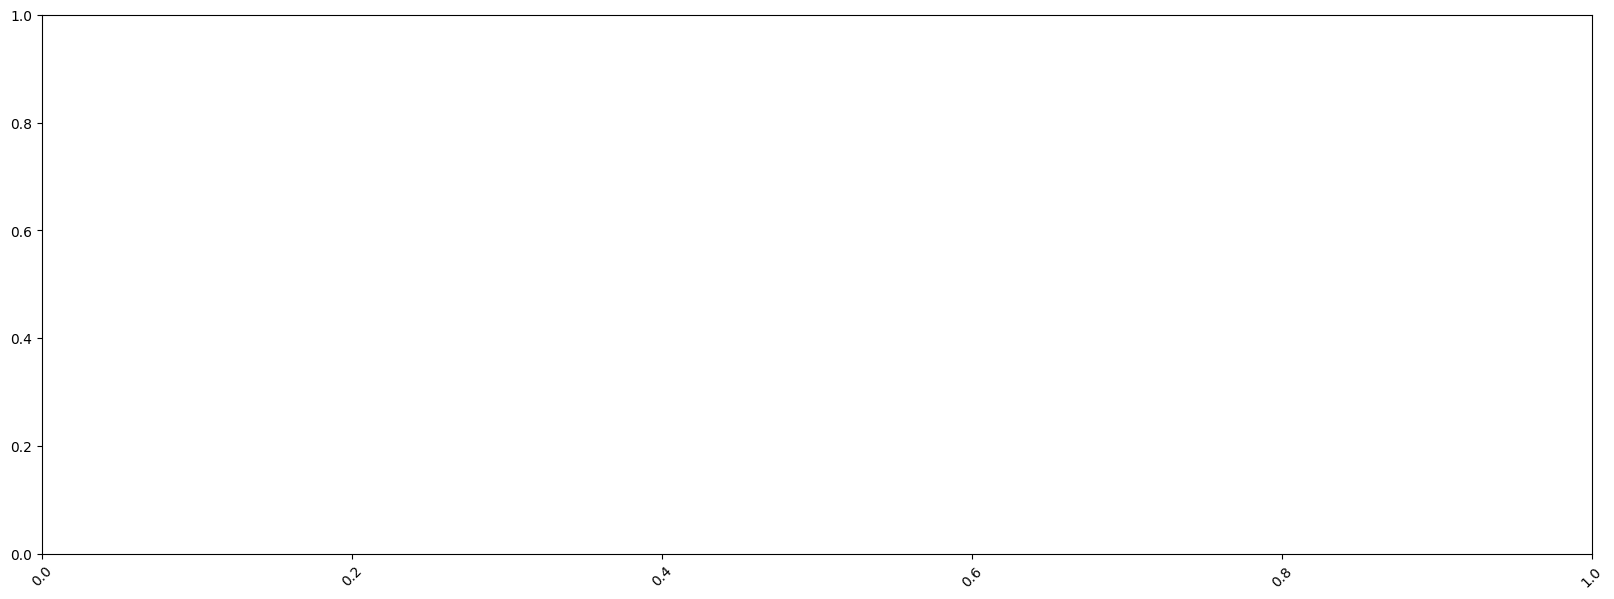

In [357]:
fig = plt.figure(figsize=(20, 7))
axis = fig.add_subplot(
        1,1,1
)

dd = [d for d in data_chunks if d[3] == "pizol"]
print(dd[-1][1])
X, Y, dates, _ = zip(*dd)
for gi, y in list(enumerate(Y)):
  base = X_WINDOW_SIZE - Y_WINDOW_SIZE
  for idx, a in list(enumerate(y))[base:]:
    print(datetime.datetime.strptime(dates[gi], "%Y-%m-%d") + datetime.timedelta(days=idx - base), idx, a)
# y = [y[0][-1] for y in Y]
# print(y[-5])
# axis.plot(dates, y)
axis.tick_params(axis='x', labelrotation=45)